In [ ]:
# default_exp patrones_espacio_temporales

In [ ]:
# export
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from criminologia_cdmx.etl import *
from functools import partial

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

# patrones_espacio_temporales

> Métodos para explorar los patrones espacio-temporales de la delincuencia y su evolución

* Hotspots con KDE
* Significancia de hotspots (https://doi.org/10.1080/13658816.2017.1406943)


## kde2D

## construye_malla

In [ ]:
# export
def construye_malla(datos, size):
    """ Regresa una malla (np.meshgrid) ajustada al extent de los datos, 
        con el tamaño de celda especificado.
        
        Args:
            datos (GeoDataFrame): carpetas o víctimas
            size (float): tamaño de las celdas (en las unidades de la proyección)
        
    """
    xmin, ymin, xmax, ymax = datos.geometry.total_bounds
    xgrid = np.arange(xmin, xmax, size)
    ygrid = np.arange(ymin, ymax, size)
    X, Y = np.meshgrid(xgrid, ygrid)
    return (X, Y)

In [ ]:
carpetas = get_carpetas_from_api(10000)
carpetas = carpetas.to_crs(32614)
malla = construye_malla(carpetas, 200)

## ajusta_bandwidth_kde

In [ ]:
# exports
def ajusta_bandwidth_kde(datos, bandwidth_space, size=1000, 
                         malla=None, n_jobs=-1, metric="euclidean"):
    """ Regresa el valor de bandwidth con mejor log likelihood.

        Parametros:
        
            datos (GeoDataFrame):  víctimas o carpetas
            bandwith_space (np.linspace):  con el espacio de búsqueda
            size (float): Tamaño de la celda (en las unidades de la proyección).
                          Si se especifica malla se ignora
            malla (np.meshgrid): la malla en la que se va a ajustar el KDE, si es None se calcula
            n_jobs (int): número de procesos a usar (default = -1)
            metric (str): métrica a usar para calcular las distancias (default euclidean)
    """
    if malla is None:
        xx, yy = construye_malla(datos, size)
    else:
        xx = malla[0]
        yy = malla[1]        
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    x = datos.geometry.x.to_numpy()
    y = datos.geometry.y.to_numpy()
    xy_train  = np.vstack([y, x]).T
    grid = GridSearchCV(KernelDensity(metric=metric), bandwidth_space, n_jobs=n_jobs)
    grid.fit(xy_train)
    return grid.best_estimator_.bandwidth

Esta función ajusta el ancho de banda para calcular un KDE en 2 dimensiones. Puede ser muy tardado.

El ancho de banda se puede calcular en cualquyier sistema de coordenadas, sin embargo es conveniente proyectarlos a coordenadas planas.

Primero ajustamos especificando el tamaño de la malla

In [ ]:
params = {'bandwidth': np.linspace(10, 10000, 100)}
bw = ajusta_bandwidth_kde(carpetas, params, size=1000)
print(bw)

312.72727272727275


También podemos especificar la malla primero

In [ ]:
params = {'bandwidth': np.linspace(10, 10000, 100)}
bw = ajusta_bandwidth_kde(carpetas, params, malla=malla)
print(bw)

312.72727272727275


## kde2D

Regresa la superficie del KDE con los parámetros especificados

In [ ]:
# export

def kde2D(datos, bandwidth, size=1000, malla=None):
    """ Regresa una matriz con la densidad de kernel para los datos.

        Parametros:
        
            datos (GeoDataFrame):  víctimas o carpetas
            bandwith: ancho del kernel gaussiano
            size (float): Tamaño de la celda (en las unidades de la proyección).
                          Si se especifica malla se ignora
            metric (str): métrica a usar para calcular las distancias (default euclidean)
            malla (np.meshgrid): la malla en la que se va a ajustar el KDE, si es None se calcula
    """    
    x = datos.geometry.x.to_numpy()
    y = datos.geometry.y.to_numpy()
    if malla is None:
        X, Y = construye_malla(datos, size)
    else:
        X = malla[0]
        Y = malla[1]
    XY = np.vstack([Y.ravel(), X.ravel()]).T
    xy_train = np.vstack([y, x]).T
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(xy_train)
    # Z = kde.score_samples(XY)
    Z = np.exp(kde.score_samples(XY))
    return X, Y, np.reshape(Z, X.shape)

Si no mandamos una malla como argumento, se calcula utilizando `size`

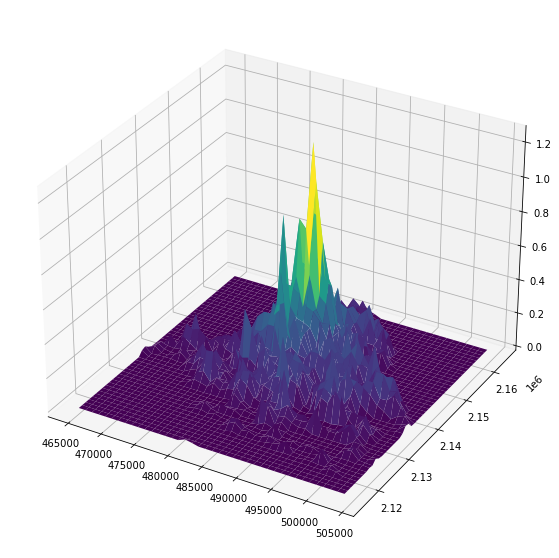

In [ ]:
xx, yy, zz = kde2D(carpetas, bw, size=1000)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax = ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')

También se puede especificar una malla con el tamaño deseado y calcular el KDE

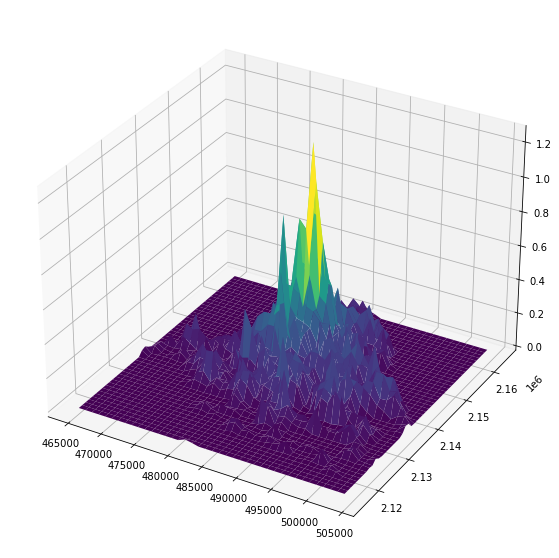

In [ ]:
malla = construye_malla(carpetas, 1000)
xx, yy, zz = kde2D(carpetas, bw, malla=malla)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax = ax.plot_surface(xx, yy, zz,cmap='viridis', edgecolor='none')

## malla_comun

In [ ]:
# export
def malla_comun(datos, size):
    """ Regresa las mallas (formato np y xarray) más pequeñas (de tamaño size)
        que contienen a todos los datos.
    
        Args:
            datos(list(GeoDataGrames)): lista con los datos para la malla común.
            size (float): tamaño de las celdas en la malla.
    """
    envolventes = [d.geometry.unary_union.envelope for d in datos]
    envolventes = gpd.GeoSeries(envolventes)
    xmin, ymin, xmax, ymax = envolventes.unary_union.envelope.bounds
    xgrid = np.arange(xmin, xmax, size)
    ygrid = np.arange(ymin, ymax, size)
    X, Y = np.meshgrid(xgrid, ygrid)
    return {'xr_grid':(xgrid, ygrid), 'np_grid':(X,Y)}

Esta función se usa dentro de `serie_tiempo_kde_categoria` y no se llama directamente.

## get_lista_datos

In [ ]:
# export
def get_lista_datos(carpetas, fechas, categorias, offset):
    """ Regresa una lista de GeoDataFrames con los datos segmentados en fechas 
        para la categoría seleccionada.
        
    """
    fechas = fechas.copy()
    fecha_inicio = fechas[0] - pd.to_timedelta(offset)
    fechas.insert(0, fecha_inicio)
    intervalos = [(fechas[i-1], f) for i, f in enumerate(fechas[1:],1)]
    datos = []
    for intervalo in intervalos:
        datos_intervalo = carpetas.loc[(carpetas['fecha_hechos'].between(*intervalo, inclusive='left')) &
                                       (carpetas['categoria'].isin(categorias))]
        datos.append(datos_intervalo)
    return datos 

In [ ]:
carpetas = get_historico_carpetas()
carpetas = agregar_categorias_carpetas(carpetas)
carpetas = carpetas.to_crs(32614)
fechas = pd.date_range(start='1/1/2020', end='3/1/2020', freq='M').to_list()
categorias = ["Homicidios dolosos"]
datos = get_lista_datos(carpetas, fechas, categorias, "30 days")
datos[0].head()

,ao_hechos,mes_hechos,fecha_hechos,ao_inicio,mes_inicio,fecha_inicio,delito,fiscalia,agencia,unidad_investigacion,...,calle_hechos,calle_hechos2,colonia_hechos,alcaldia_hechos,competencia,longitud,latitud,tempo,geometry,categoria
895799,2020.0,Enero,2020-01-01 04:50:00,2020,Enero,2020-01-01 05:59:10,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN ESTRATÉGICA DEL DELI...,2,1 CON DETENIDO 1 C/D,...,15 Y AVENIDA GUADALUPE,NaN,GUADALUPE PROLETARIA,GUSTAVO A MADERO,NaN,-99.156937,19.521753,NaN,POINT (483534.561 2158567.439),Homicidios dolosos
895810,2020.0,Enero,2020-01-01 07:30:00,2020,Enero,2020-01-01 08:43:13,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN ESTRATÉGICA DEL DELI...,2,1 CON DETENIDO 1 C/D,...,PIRULES,NaN,TLALPEXCO,GUSTAVO A MADERO,NaN,-99.128763,19.544280,NaN,POINT (486492.381 2161057.661),Homicidios dolosos
895835,2020.0,Enero,2020-01-01 11:00:00,2020,Enero,2020-01-01 11:04:10,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN TERRITORIAL EN IZTAP...,IZP-9,UI-3SD,...,elisa,NaN,2A. AMPLIACIÓN SANTIAGO ACAHUALTEPEC,IZTAPALAPA,NaN,-99.015140,19.347795,NaN,POINT (498409.849 2139310.995),Homicidios dolosos
895836,2020.0,Enero,2020-01-01 09:55:00,2020,Enero,2020-01-01 11:05:21,HOMICIDIO POR ARMA BLANCA,FISCALÍA DE INVESTIGACIÓN TERRITORIAL EN MIGUE...,H1,UI-1SD,...,F.C. NACIONALES DE MEXICO,AND. NUEVA GALICIA,NUEVA ESPAÑA,AZCAPOTZALCO,NaN,-99.189655,19.498750,NaN,POINT (480099.007 2156025.577),Homicidios dolosos
896408,2020.0,Enero,2020-01-02 19:20:00,2020,Enero,2020-01-02 19:53:43,HOMICIDIO POR ARMA DE FUEGO,FISCALÍA DE INVESTIGACIÓN ESTRATÉGICA DEL DELI...,2,1 CON DETENIDO 1 C/D,...,25 DE SEPTIEMBRE DE 1873,PUENTE QUEMADO,LEYES DE REFORMA 3A SECCIÓN,IZTAPALAPA,NaN,-99.061941,19.376333,NaN,POINT (493495.517 2142469.932),Homicidios dolosos


## serie_tiempo_kde_categoria

In [ ]:
# export
def serie_tiempo_kde_categoria(carpetas, fechas, size, categorias, offset,
                               malla = None,
                               grid_search={'bandwidth': np.linspace(10, 10000, 100)},
                               bw=None):
    """ Ajusta kdes egregando los datos sobre cada categoria e intervalo de fecha.

       Args:
           carpetas (GeoDataFrame): Incidentes (carpetas/victimas), si viene `malla` se ignora size
           size (float): Tamaño de la celda (en las unidades de la proyección)
           fechas list(pd.datetime): extremos (derechos) de los intervalos de tiempo
           categorias: Lista de categorías para calcular el KDE
           offset: intervalo para agregar antes de la primera fecha, 
                   p.ej: "30 days" si los intervalos son mensuales
           malla (dict): Obtenida con `malla_comun`. 
           grid_search: {'bandwidth': np.linspace(0.001, 0.1, 100)} valores para ajustar el bandwidth (se usa sólo si bandwidth es nulo)
           bandwidth: Si no se especifica grid_search, se tiene que dar un valor de bandwidth
           **kwargs: argumentos extra que se pasan a `kde2D`

       returns:
       (xx, yy) [zz]: la tupla (xx, yy) es el grid común de los kdes, la lista contiene los valores de z para cada intervalo
    """
    datos = get_lista_datos(carpetas, fechas, categorias, "30 days")
    if malla is None:
        malla = malla_comun(datos, size)
    if bw is None:
        bw = ajusta_bandwidth_kde(datos_intervalo, size, grid_search)
    kde2D_p = lambda d: kde2D(d, bw, size=size, malla=malla['np_grid']) 
    kdes = map(kde2D_p, datos)
    kdes = [k[2] for k in kdes]
    tiempo = fechas
    serie_kde = np.array(kdes)
    lat = malla['xr_grid'][1]
    lon = malla['xr_grid'][0]
    serie_kde = xr.DataArray(serie_kde, 
                             coords={"latitud":lat, "longitud":lon, 'tiempo':tiempo}, 
                             dims=["tiempo","latitud", "longitud"])  
    return serie_kde

In [ ]:
fechas = pd.date_range(start='1/1/2020', end='3/1/2020', freq='M').to_list()
categorias = ["Homicidios dolosos"]
xr_kde = serie_tiempo_kde_categoria(carpetas, fechas, 1000, categorias, "30 days", bw=1000)
assert type(xr_kde) == xr.DataArray
xr_kde

<xarray.DataArray (tiempo: 2, latitud: 43, longitud: 38)>
array([[[2.24034265e-61, 2.11172137e-55, 7.32258396e-50, ...,
         1.39403333e-12, 1.95682704e-14, 1.01050216e-16],
        [5.32478161e-59, 5.01541519e-53, 1.73913870e-47, ...,
         8.45523954e-13, 1.18687560e-14, 6.12900540e-17],
        [2.32036761e-56, 4.40511485e-51, 1.51954162e-45, ...,
         1.88661895e-13, 2.64827742e-15, 1.36756596e-17],
        ...,
        [8.99073620e-60, 1.01430835e-53, 4.22939828e-48, ...,
         8.98927735e-34, 2.15106357e-37, 1.92992409e-41],
        [4.45595866e-62, 5.08469072e-56, 2.13662529e-50, ...,
         5.86138370e-37, 1.07542257e-40, 9.26654855e-45],
        [8.35234410e-65, 9.55385224e-59, 4.02109087e-53, ...,
         7.61316943e-40, 3.35576639e-44, 1.78402766e-48]],

       [[2.38478474e-48, 4.55356526e-43, 3.19859655e-38, ...,
         3.08928355e-14, 1.78120074e-13, 3.77810027e-13],
        [1.08842935e-46, 2.07827312e-41, 1.45985768e-36, ...,
         1.12557500e-12, 6.48977341e-12, 1.37654416e-11],
        [1.82752719e-45, 3.48947258e-40, 2.45113449e-35, ...,
         1.50867823e-11, 8.69864723e-11, 1.84506781e-10],
        ...,
        [2.46258641e-46, 4.20274708e-41, 2.63894001e-36, ...,
         2.10102236e-33, 8.83046087e-38, 1.36535135e-42],
        [4.52312089e-48, 7.71885510e-43, 4.84622917e-38, ...,
         1.74890278e-35, 7.35052237e-40, 1.13651786e-44],
        [3.05636632e-50, 5.21558516e-45, 3.27435395e-40, ...,
         5.35557915e-38, 2.25091437e-42, 3.48030275e-47]]])
Coordinates:
  * latitud   (latitud) float64 2.121e+06 2.122e+06 ... 2.162e+06 2.163e+06
  * longitud  (longitud) float64 4.656e+05 4.666e+05 ... 5.016e+05 5.026e+05
  * tiempo    (tiempo) datetime64[ns] 2020-01-31 2020-02-29

Esta función regresa un `DataArray` de [xarray](https://docs.xarray.dev/en/stable/index.html) con los KDEs etiquetados por los extremos de los intervalos. Podemos inspeccionar rápidamete cualquiera de los KDEs obtenidos.

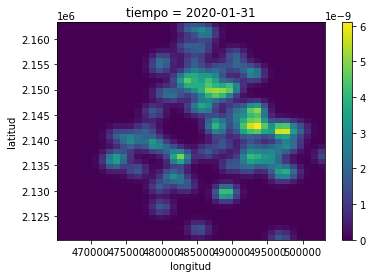

In [ ]:
xr_kde.isel(tiempo=0).plot()

En el ejemplo anterior seleccionamos por el índice (`xr_kde.isel(tiempo=0)`), también podemos seleccionar por el valor de la etiqueta

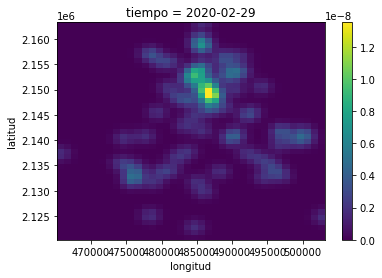

In [ ]:
xr_kde.sel(tiempo=fechas[1]).plot()

## serie_razones_de_eventos

In [ ]:
# export
def serie_razones_de_eventos(carpetas, fechas, categorias, offset, size, bw):
    """ Regresa un xr.Dataset con los xr.DataArray para lass series por categoría, base y las razones."""
    datos_categoria = get_lista_datos(carpetas, fechas, categorias, offset)
    categorias_todas = list(carpetas[carpetas.categoria.notnull()]['categoria'].unique())
    categorias_todas = set(categorias_todas) - set(categorias)
    datos_base = get_lista_datos(carpetas, fechas, categorias_todas, offset)
    datos_completos = datos_categoria + datos_base
    malla = malla_comun(datos_completos, size)
    kdes_categoria = serie_tiempo_kde_categoria(carpetas, fechas, size,
                                                categorias, offset, bw=bw, malla=malla)
    kdes_base = serie_tiempo_kde_categoria(carpetas, fechas, size,
                                                categorias_todas, offset, bw=bw, malla=malla)
    # TODO: vectorizar esta operación np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    razones = kdes_categoria / kdes_base
    ds = xr.Dataset({"Serie categorias":kdes_categoria, 
                     "Serie base":kdes_base, 
                     "Serie razones":razones})    
    return ds

Calculamos la serie de mapas de razones

In [ ]:
fechas = pd.date_range(start='1/1/2020', end='3/1/2020', freq='M').to_list()
categorias = ["Homicidios dolosos"]
series = serie_razones_de_eventos(carpetas,fechas, ["Homicidios dolosos"], "30 days", 1000, 1000)
series

[Timestamp('2020-01-31 00:00:00', freq='M'), Timestamp('2020-02-29 00:00:00', freq='M')]


<xarray.Dataset>
Dimensions:           (latitud: 50, longitud: 40, tiempo: 2)
Coordinates:
  * latitud           (latitud) float64 2.115e+06 2.116e+06 ... 2.164e+06
  * longitud          (longitud) float64 4.648e+05 4.658e+05 ... 5.038e+05
  * tiempo            (tiempo) datetime64[ns] 2020-01-31 2020-02-29
Data variables:
    Serie categorias  (tiempo, latitud, longitud) float64 2.673e-88 ... 2.456...
    Serie base        (tiempo, latitud, longitud) float64 5.624e-68 ... 3.474...
    Serie razones     (tiempo, latitud, longitud) float64 4.752e-21 ... 7.071...

El resultado es un `xr.Dataset` que contiene las dos series (base y de categoría) y la razón entre ellas. Podemos acceder a cualquiera de ellas por etiqueta:

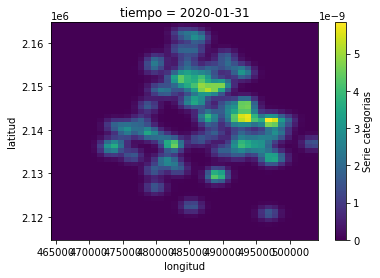

In [ ]:
series["Serie categorias"].isel(tiempo=0).plot()

Podemos visualizar las tres superficies resultantes

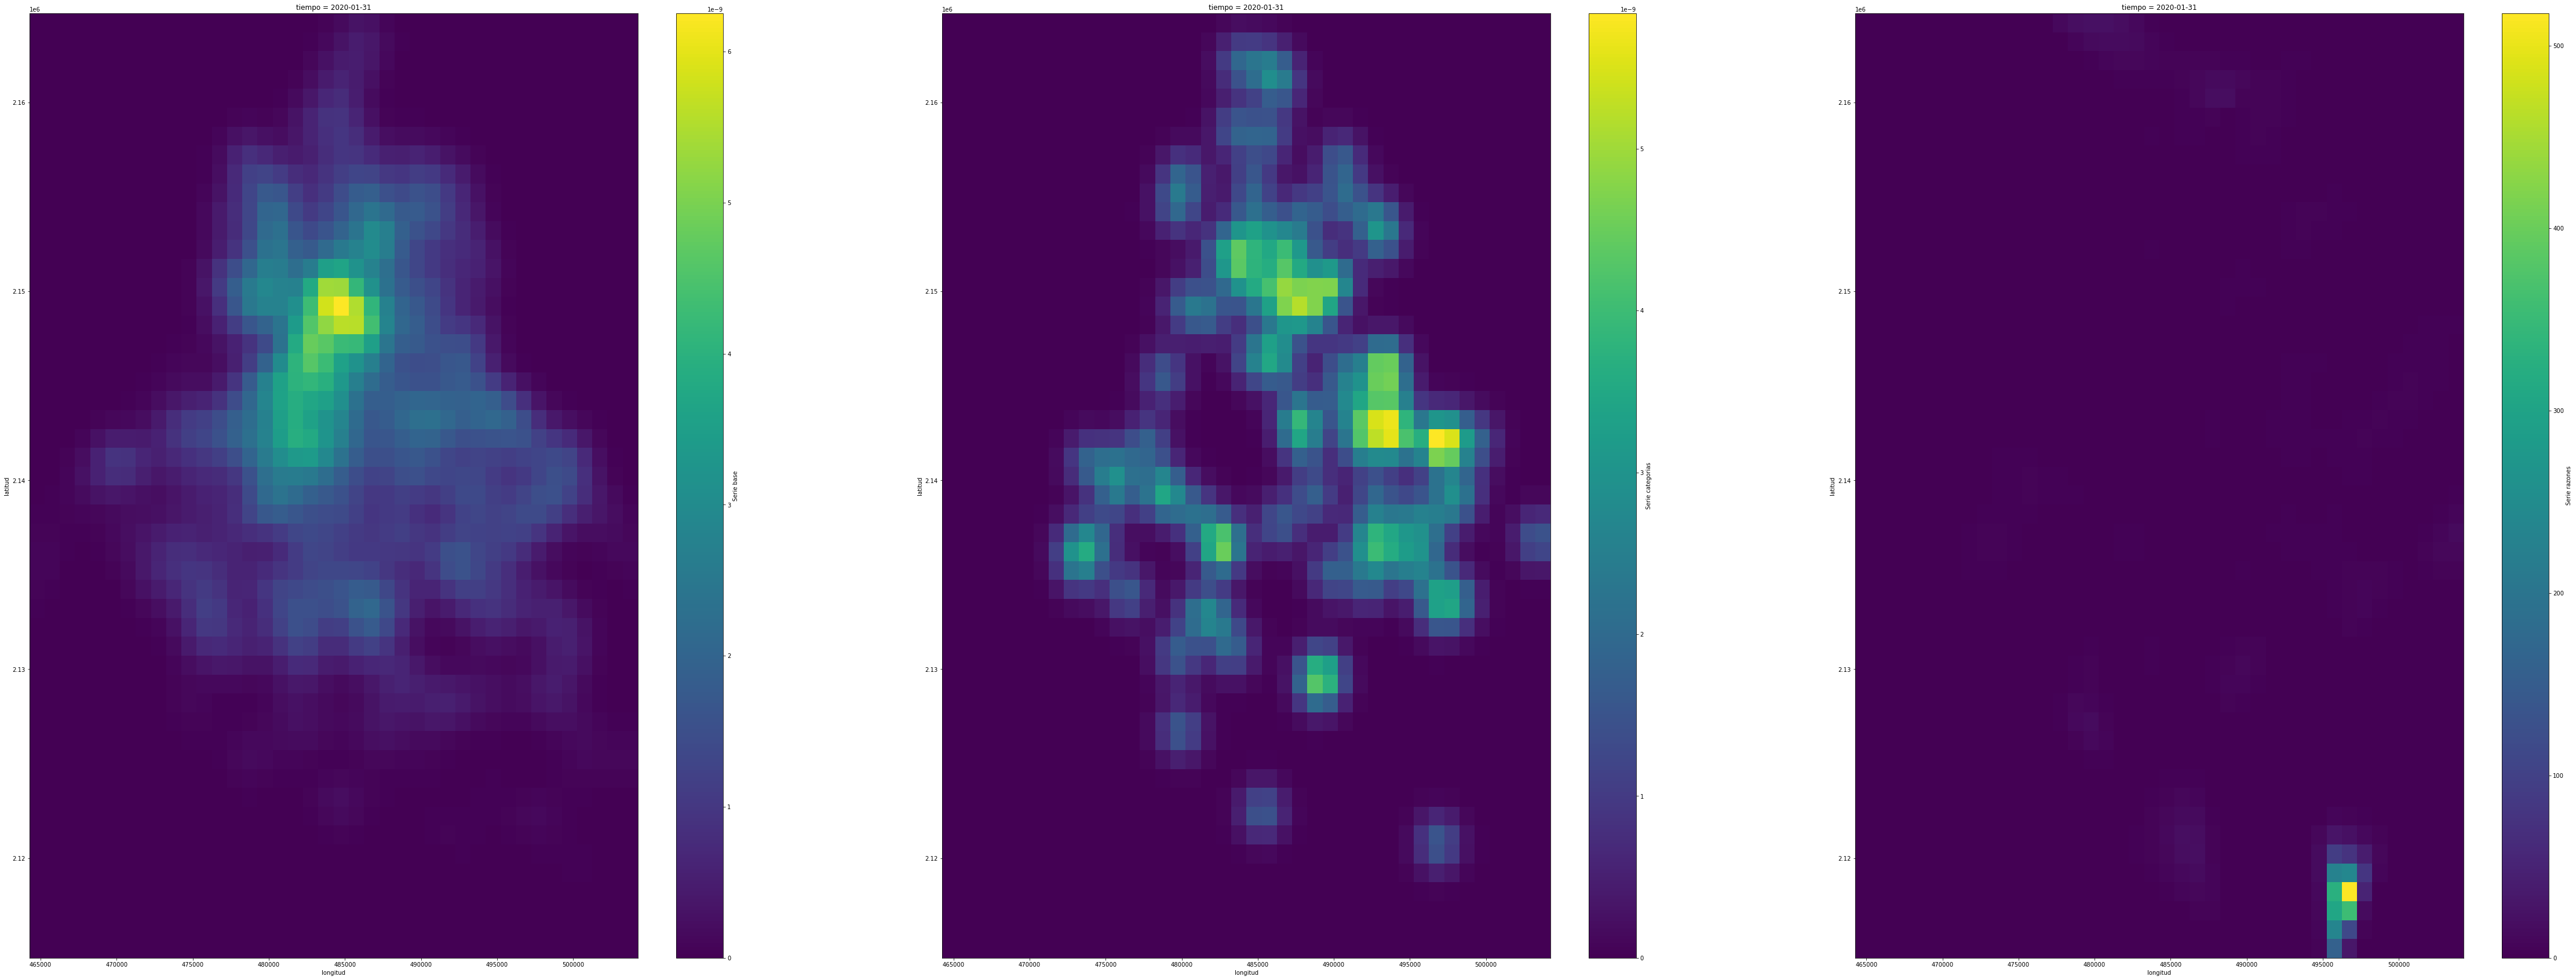

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(80,30))
axes = axes.ravel()
series["Serie base"].isel(tiempo=0).plot(ax=axes[0])
series["Serie categorias"].isel(tiempo=0).plot(ax=axes[1])
series["Serie razones"].isel(tiempo=0).plot(ax=axes[2])

## serie_mapas_intensidad

In [ ]:
# export
def serie_mapas_intensidad(carpetas, fechas, categorias, offset, size, bw):
    """Regresa los mapas de razon y las intensidades de la categoría para las `fechas` seleccionadas."""
    series = serie_razones_de_eventos(carpetas, fechas, categorias, offset, size, bw)
    avg = series['Serie razones'].mean(dim='tiempo')
    std = series['Serie razones'].std(dim='tiempo')
    intensidad = (series['Serie razones'] - avg) / std
    series = series.assign(intensidad=intensidad)
    ps = []
    for i in range(len(fechas)):
        n_h = (series['Serie razones'].isel(tiempo=i) >= series['Serie razones'])
        n_h = n_h.sum(dim='tiempo')
        p = n_h / (len(fechas) + 1)
        ps.append(p)
    ps = xr.concat(ps, dim=series.coords['tiempo'])
    series = series.assign(p_values=ps)
    return series

Finalmente, tenemos la función `serie_mapas_intensidad` que encapsula la funcionalidad completa. Calcula de forma simultanea las series de tioempo de todas las categorías, la de las categorías seleccionadas, la el cociente entre estas, la intensidad (o sea los z-scores del cociente) y los mapas de significancia.

La función regresa un `xr.Dataset` con variables para cada una de las series.

In [ ]:
fechas = pd.date_range(start='1/1/2020', end='4/1/2020', freq='M').to_list()
series = serie_mapas_intensidad(carpetas, fechas, ["Homicidios dolosos"], "30 days", 1000, 1000)
series

<xarray.Dataset>
Dimensions:           (latitud: 50, longitud: 41, tiempo: 3)
Coordinates:
  * latitud           (latitud) float64 2.115e+06 2.116e+06 ... 2.164e+06
  * longitud          (longitud) float64 4.648e+05 4.658e+05 ... 5.048e+05
  * tiempo            (tiempo) datetime64[ns] 2020-01-31 2020-02-29 2020-03-31
Data variables:
    Serie categorias  (tiempo, latitud, longitud) float64 2.673e-88 ... 2.154...
    Serie base        (tiempo, latitud, longitud) float64 5.624e-68 ... 5.381...
    Serie razones     (tiempo, latitud, longitud) float64 4.752e-21 ... 4.003...
    intensidad        (tiempo, latitud, longitud) float64 -0.7261 ... -1.385
    p_values          (tiempo, latitud, longitud) float64 0.25 0.25 ... 0.25

Además de las series que ya hemos visto, las dos nuevas que producimos aquí: intensidad y significancia, nos ayudan a identificar cuando la categoría seleccionada tiene un comportamiento anómal

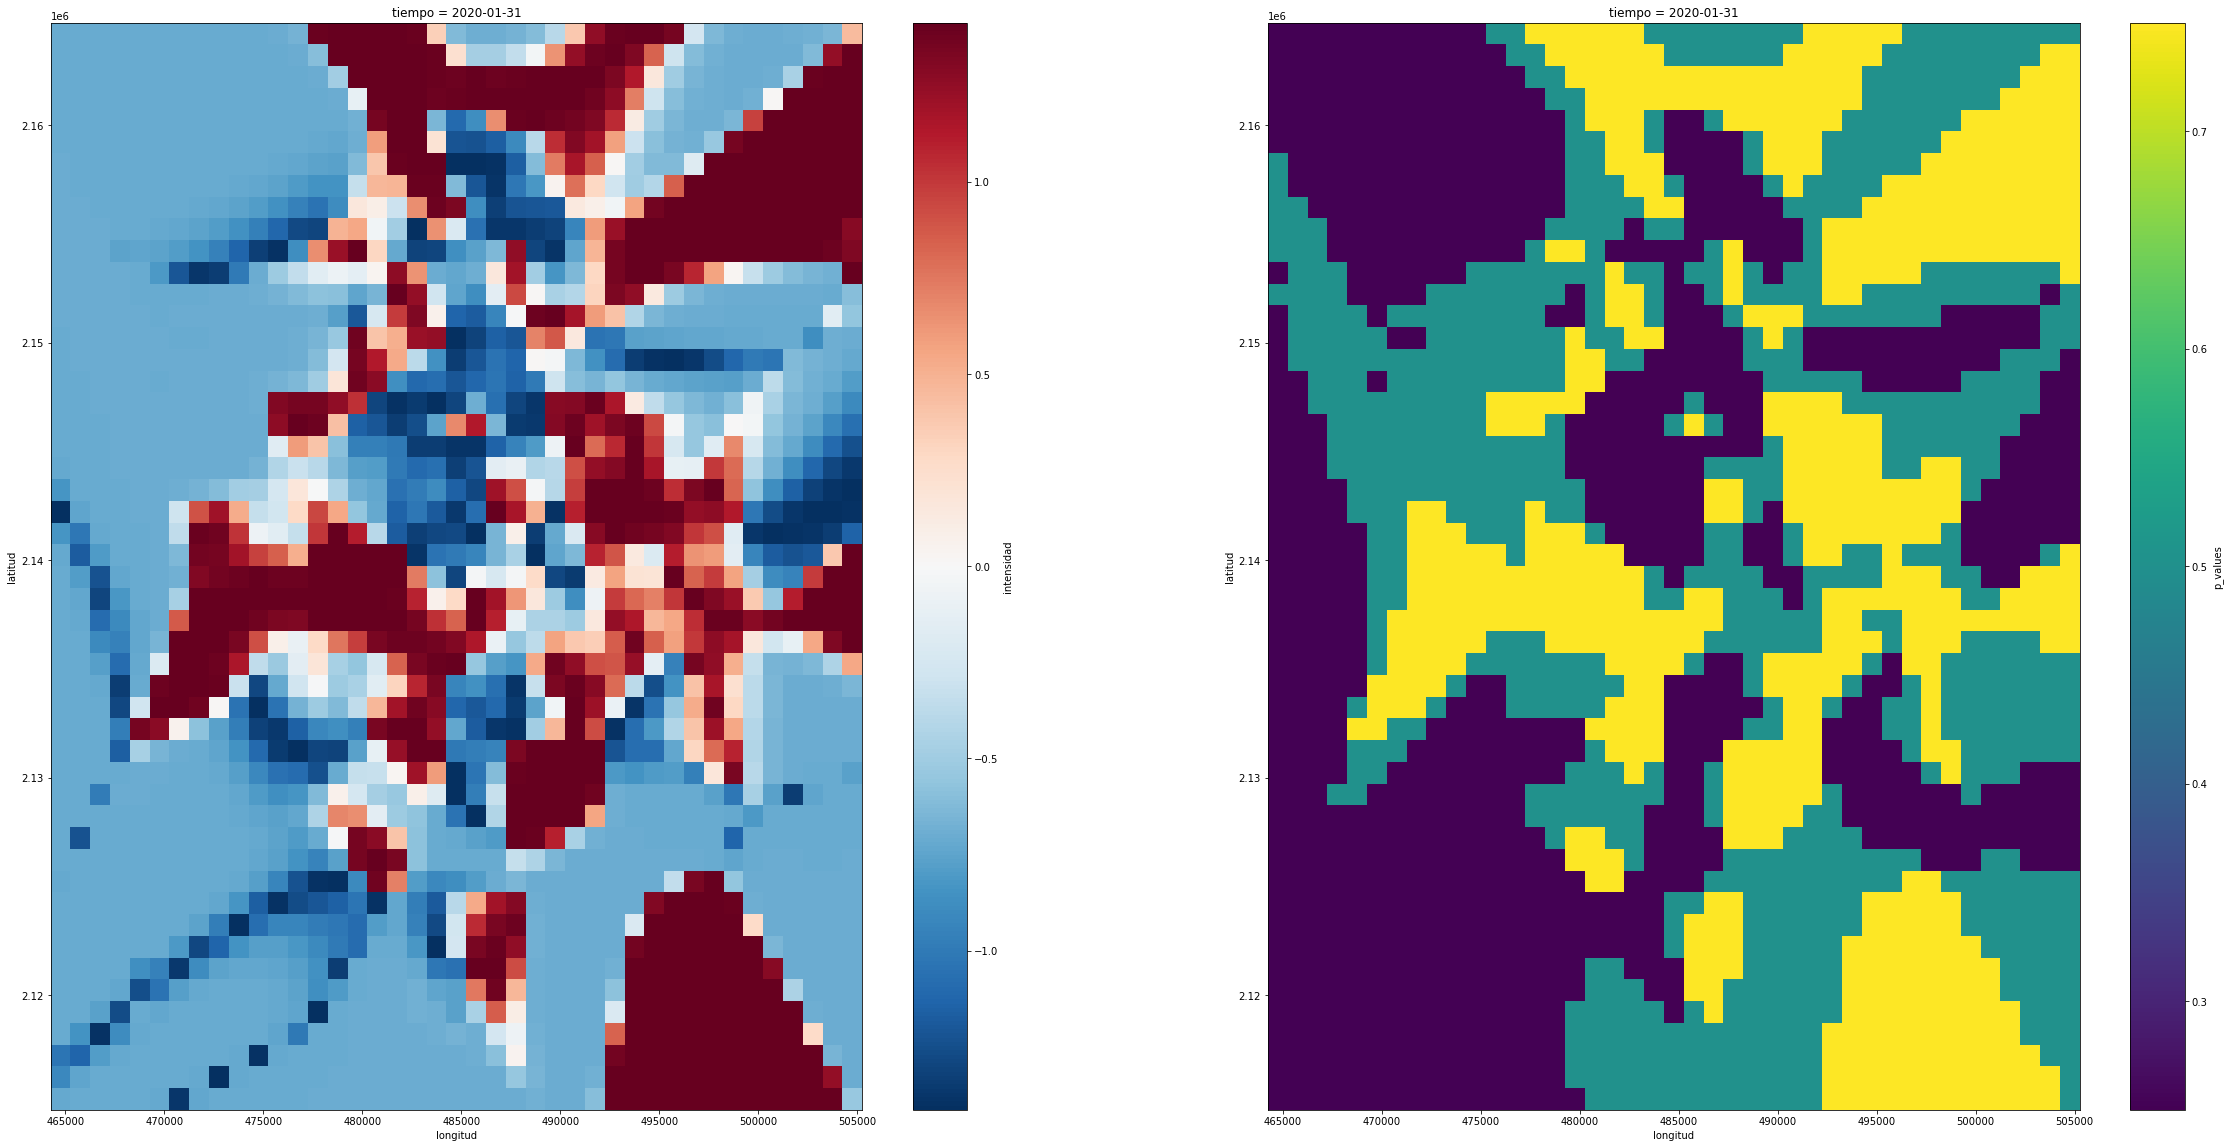

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(40,20))
axes = axes.ravel()
series["intensidad"].isel(tiempo=0).plot(ax=axes[0])
series["p_values"].isel(tiempo=0).plot(ax=axes[1])


## p_value_maps

In [ ]:
carpetas.fecha_hechos.min()

Timestamp('1906-06-02 19:00:00')